In [127]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

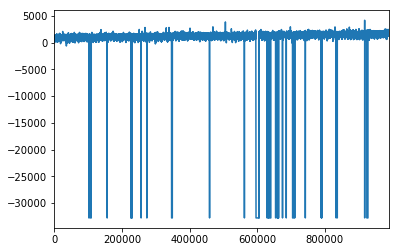

In [142]:
dfSL = pd.read_csv('Galveston.csv', header=None)
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
fill_in = dfSL.loc[dfSL['sealevel']<-5000].median()[4]
dfSL['sealevel'].plot()
plt.show()

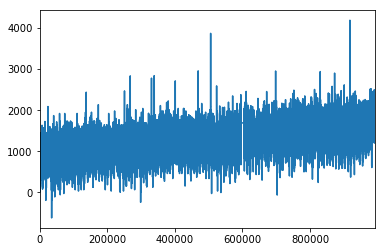

In [143]:
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace= True)
dfSL['sealevel'].plot()
plt.show()

In [144]:
n_hours = 365*24
sl_year = {}
for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
gev= {}
for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        gev[year] = max(np.array(sealevel)-np.mean(sealevel))
        

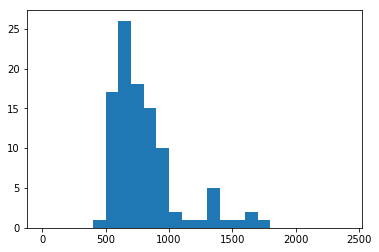

In [257]:
plt.hist(list(gev.values()), bins=np.arange(0, 2500, 100))
plt.show()

In [146]:
data_meas = list(gev.values())

## Likelihood Function:

In [155]:
def likelihood(parameters, data_meas):
    u, s, shape = parameters                                                 
    prod = 1
    for i in range(len(data_meas)):
        pdf = stats.genextreme.pdf(x=data_meas[i], loc=u, scale=s, c=shape)
        if (pdf==0):
            return -np.inf
        prod += np.log(pdf)
    return prod

## Prior Distribution:

In [168]:
def prior(parameters):
    u, s, shape = parameters
    u_pdf = stats.norm.pdf(x=u, loc=0, scale=100)
    shape_pdf = stats.norm.pdf(x=shape, loc=0, scale=100)
    if s >= 1000 or s <= 0 or u_pdf==0 or shape_pdf==0:
        return -np.inf
    else:
        return np.log(u_pdf)+np.log(1/1000)+np.log(shape_pdf)

## Posterior Distribution:

In [176]:
def logpost(parameters, data_meas):
    pi = prior(parameters)
    if pi == -np.inf:
        return -np.inf
    L = likelihood(parameters, data_meas)
    return L + pi

## Metropolis-Hastings Algorithm


In [225]:
eps = 0.0001
d = 3                                                                                                                                                                                                                                                                                                  
I_d = np.identity(d)
S_d = (2.4)**2/d
def update_cov(X):
    cov = np.cov(X)
    return S_d*cov + I_d*eps*S_d

In [238]:
class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [239]:
def mcmc(problem, n_iter):

    u = [problem.current.state[0]] 
    s = [problem.current.state[1]]
    shape = [problem.current.state[2]]
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    
    with Pool(8) as p:
        for t in range(n_iter):
            S += 1
            nextMove, nextValue = problem.random_move(t, [u, s, shape])
            delta_obj = np.exp(nextValue - lpost[-1])
            if delta_obj > 1:
                # the proposed move is an improvement, so accept w.p. 1
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                shape.append(nextMove[2])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                # the proposed move is worse; accept with probability exp[delta_obj/T]
                p_accept = delta_obj
                accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
                if accept:
                    n_accept += 1
                    u.append(nextMove[0])
                    s.append(nextMove[1])
                    shape.append(nextMove[2])
                    lpost.append(nextValue)
                    problem.current.state = nextMove
                    problem.current.value = nextValue
                else:
                    u.append(u[-1])
                    s.append(s[-1])
                    shape.append(shape[-1])
                    lpost.append(lpost[-1])

    return (u, s, shape, lpost, n_accept/S)

In [280]:
state = State([600, 20, 0.001], logpost([600, 20, 0.001], data_meas))
problem = ProblemMCMC(state, logpost, [20, 2, 1], data_meas, 4000)

In [281]:
u, s, shape, ls, ar = mcmc(problem, 10000)

-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf


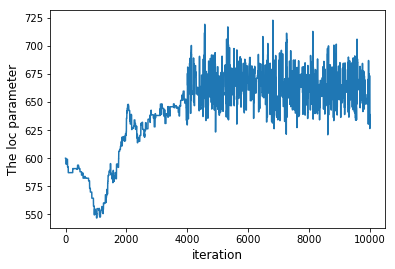

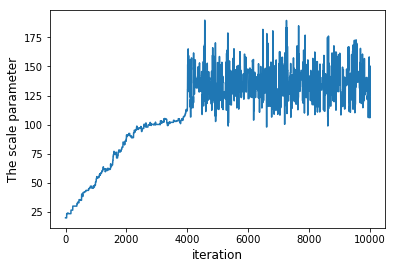

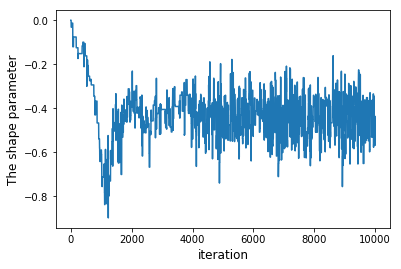

In [285]:
plt.plot(u)
plt.ylabel('The loc parameter', fontsize=12)
plt.xlabel('iteration', fontsize=12)
plt.show()

plt.plot(s)
plt.ylabel('The scale parameter', fontsize=12)
plt.xlabel('iteration', fontsize=12)
plt.show()

plt.plot(shape)
plt.ylabel('The shape parameter', fontsize=12)
plt.xlabel('iteration', fontsize=12)
plt.show()

In [284]:
u1 = np.mean(u[6000:])
s1 = np.mean(s[6000:])
shape1 = np.mean(shape[6000:])
print (shape1, s1, u1)

-0.444849635632 135.524548298 663.315487413


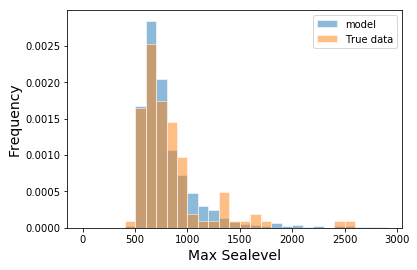

In [287]:
samples = stats.genextreme.rvs(c=shape1, loc=u1, scale=s1, size=1000)
plt.hist(samples, bins=np.arange(0, 3000, 100), normed=True, edgecolor='white', alpha=0.5, label='model')
plt.hist(data_meas, bins=np.arange(0, 3000, 100), normed=True, edgecolor='white', alpha=0.5, label='True data')
plt.legend()
plt.xlabel('Max Sealevel', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()